<a href="https://colab.research.google.com/github/pavelkochkin1/policy-prolongation-mindset/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages importing and constant setting

In [49]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from joblib import dump, load

sns.set(rc={'figure.figsize':(12,8)})
sns.set(style="whitegrid", palette='Dark2')

In [50]:
RANDOM_STATE = 73
TEST_SIZE = 0.2
TARGET_NAME = 'POLICY_IS_RENEWED'

# Data loading

In [205]:
data = pd.read_csv('data/data.csv', index_col='POLICY_ID')
data.head()

,POLICY_BEGIN_MONTH,POLICY_END_MONTH,POLICY_IS_RENEWED,POLICY_SALES_CHANNEL,POLICY_SALES_CHANNEL_GROUP,POLICY_BRANCH,POLICY_MIN_AGE,POLICY_MIN_DRIVING_EXPERIENCE,VEHICLE_ENGINE_POWER,VEHICLE_IN_CREDIT,VEHICLE_SUM_INSURED,INSURER_GENDER,POLICY_CLM_N,POLICY_CLM_GLT_N,POLICY_PRV_CLM_N,CLIENT_HAS_DAGO,CLIENT_HAS_OSAGO,POLICY_HAS_COMPLAINTS,POLICY_YEARS_RENEWED_N,POLICY_DEDUCT_VALUE,POLICY_PRICE_CHANGE
POLICY_ID,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,39,1,1,51,12,245.0,0,1283202.0,0,0,0,6,1,0,0,0,0.0,-1.00
2,1,1,1,50,5,1,35,7,140.0,0,453000.0,1,0,0,0,1,1,0,4,0.0,-0.05
3,1,1,1,52,6,1,41,6,129.0,0,647718.0,0,0,0,1,0,0,0,1,12518.0,-0.07
4,1,1,1,50,5,1,36,12,170.0,0,757795.0,1,0,0,0,1,1,0,6,15000.0,0.05
5,1,1,0,52,6,0,42,5,102.0,0,604500.0,0,0,0,6,0,0,0,0,50000.0,0.17


In [207]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89243 entries, 1 to 96605
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   POLICY_BEGIN_MONTH             89243 non-null  int64  
 1   POLICY_END_MONTH               89243 non-null  int64  
 2   POLICY_IS_RENEWED              89243 non-null  int64  
 3   POLICY_SALES_CHANNEL           89243 non-null  int64  
 4   POLICY_SALES_CHANNEL_GROUP     89243 non-null  int64  
 5   POLICY_BRANCH                  89243 non-null  int64  
 6   POLICY_MIN_AGE                 89243 non-null  int64  
 7   POLICY_MIN_DRIVING_EXPERIENCE  89243 non-null  int64  
 8   VEHICLE_ENGINE_POWER           89243 non-null  float64
 9   VEHICLE_IN_CREDIT              89243 non-null  int64  
 10  VEHICLE_SUM_INSURED            89243 non-null  float64
 11  INSURER_GENDER                 89243 non-null  int64  
 12  POLICY_CLM_N                   89243 non-null 

In [208]:
data.duplicated().sum()

7

In [209]:
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

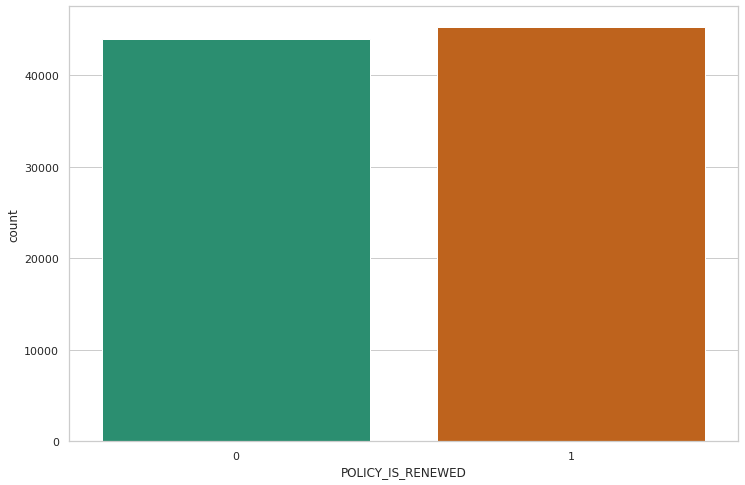

In [210]:
sns.countplot(data=data, x=TARGET_NAME)

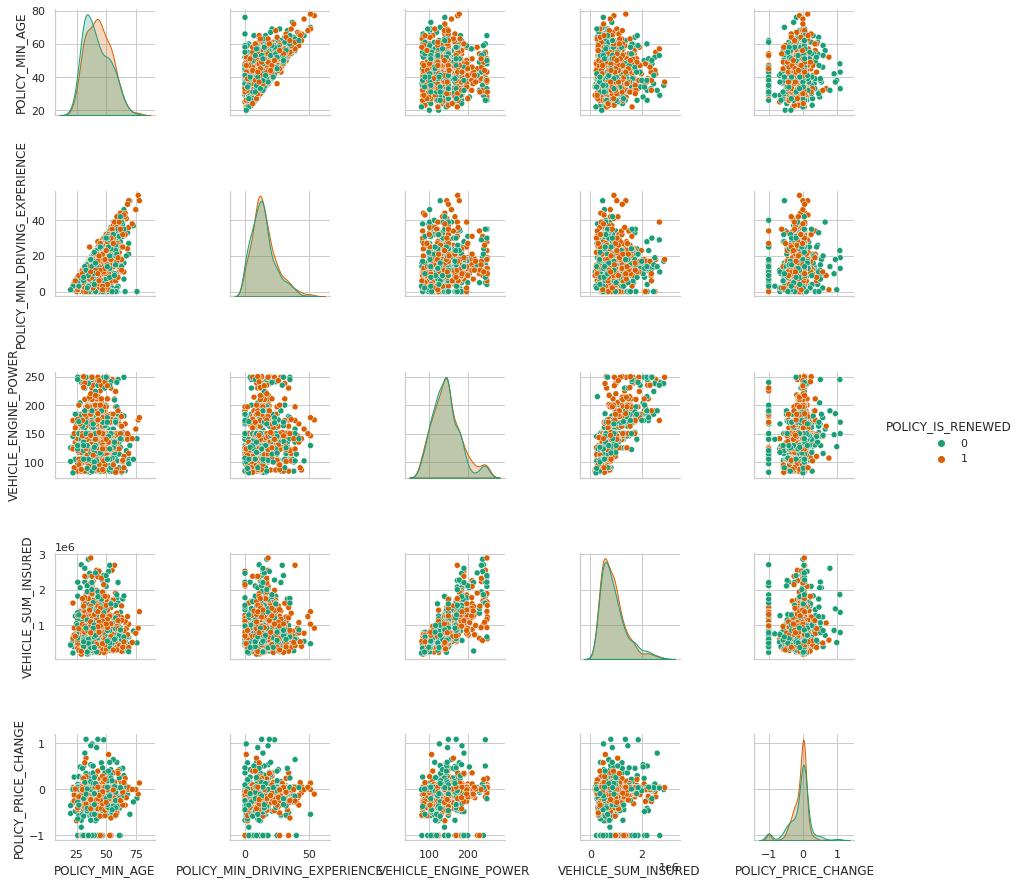

In [211]:
sns.pairplot(data=data.sample(1000), hue=TARGET_NAME, vars=num_cols, diag_kind='kde')

# Train Test Split

In [ ]:
#from sklearn.model_selection import train_test_split

#train_df, test_df = train_test_split(data, 
#                                     test_size=TEST_SIZE, 
#                                     stratify=data[TARGET_NAME],
#                                     random_state=RANDOM_STATE)

#train_df.to_csv('data/train.csv')
#test_df.to_csv('data/test.csv')

**I divided the data and captured it for more honest experiments.**

# Data loading

In [ ]:
train_df = pd.read_csv('data/train.csv', index_col='POLICY_ID')
test_df = pd.read_csv('data/test.csv', index_col='POLICY_ID')

print(f'shapes: \n train - {train_df.shape}\n test - {test_df.shape}')

shapes: 
 train - (71388, 21)
 test - (17848, 21)


## LightAutoML



In [ ]:
!pip install -U lightautoml

In [52]:
# Standard python libraries
import time

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.text_presets import TabularAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDecoNLP

from sklearn.metrics import recall_score, precision_score, f1_score, plot_precision_recall_curve, accuracy_score

In [53]:
THREADS = 4 # threads number for automl's model (lightgbm and linear models)
FOLDS = 5 # number of folds in LightAutoML's cross-validation
TIMEOUT = 3*3600 # limit in seconds for model to train

In [54]:
np.random.seed(RANDOM_STATE)

In [55]:
task = Task('binary', )

roles = {'target': TARGET_NAME,
         'category': cat_cols,
         'numeric': num_cols
         }

In [ ]:
%%time 

automl = TabularAutoML(task = task, 
                               timeout = TIMEOUT,
                               cpu_limit = THREADS,
                               reader_params = {'n_jobs': THREADS, 'cv': FOLDS, 'random_state': RANDOM_STATE},
                               general_params = {'use_algos': [['lgb']]},
                               #tuning_params = {'max_tuning_time': 25 * 60}, # Set 25 minutes for LGBM params tuning
                               lgb_params = {'default_params': {'num_trees': 100000, 'learning_rate': 0.005, 'early_stopping_rounds': 1000}, # Set smaller LR and more ES rounds
                                             'freeze_defaults': True},
                              )

oof_pred = automl.fit_predict(train_df, roles = roles)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

Start automl preset with listed constraints:
- time: 10800 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (71388, 21)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 10788.164511919022 secs
Start fitting Selector_LightGBM ...

===== Start working with fold 0 for Selector_LightGBM =====

Training until validation scores don't improve for 1000 rounds
[100]	valid's auc: 0.670889
[200]	valid's auc: 0.672795
[300]	valid's auc: 0.674234
[400]	valid's auc: 0.67541
[500]	valid's auc: 0.676151
[600]	valid's auc: 0.676845
[700]	valid's auc: 0.67714
[800]	valid's auc: 0.677417
[900]	valid's auc: 0.677577
[1000]	valid's auc: 0.677743
[1100]	valid's auc: 0.677717
[1200]	valid's auc: 0.677553
[1300]	valid's auc: 0.677464
[1400]	valid's auc: 0.67717
[1500]	valid's auc: 0.677069
[1600]	valid's auc: 0.676695
[1700]	valid's auc: 0.676366
[1800]	valid's auc: 0.676084
[1900]	valid's auc: 0.675835
[2000]	valid's auc: 0.67569
Early stopping, best 

In [ ]:
%%time

# Accurate feature importances calculation (Permutation importances) -  can take long time to calculate
accurate_fi = automl.get_feature_scores('accurate', test_df.sample(1000), silent = False)

LightAutoML used 20 feats
1/20 Calculated score for POLICY_PRV_CLM_N: 0.0010880
2/20 Calculated score for POLICY_SALES_CHANNEL_GROUP: 0.0027960
3/20 Calculated score for POLICY_MIN_AGE: -0.0000640
4/20 Calculated score for POLICY_CLM_GLT_N: 0.0193720
5/20 Calculated score for CLIENT_HAS_OSAGO: 0.0063320
6/20 Calculated score for VEHICLE_IN_CREDIT: -0.0009640
7/20 Calculated score for POLICY_MIN_DRIVING_EXPERIENCE: 0.0020600
8/20 Calculated score for POLICY_END_MONTH: 0.0023680
9/20 Calculated score for INSURER_GENDER: 0.0020440
10/20 Calculated score for POLICY_BEGIN_MONTH: 0.0022560
11/20 Calculated score for POLICY_PRV_CLM_GLT_N: -0.0023720
12/20 Calculated score for POLICY_PRICE_CHANGE: 0.1105200
13/20 Calculated score for VEHICLE_ENGINE_POWER: 0.0082640
14/20 Calculated score for POLICY_CLM_N: 0.0019760
15/20 Calculated score for POLICY_BRANCH: 0.0137360
16/20 Calculated score for CLIENT_HAS_DAGO: 0.0016320
17/20 Calculated score for VEHICLE_MAKE: 0.0003400
18/20 Calculated score f

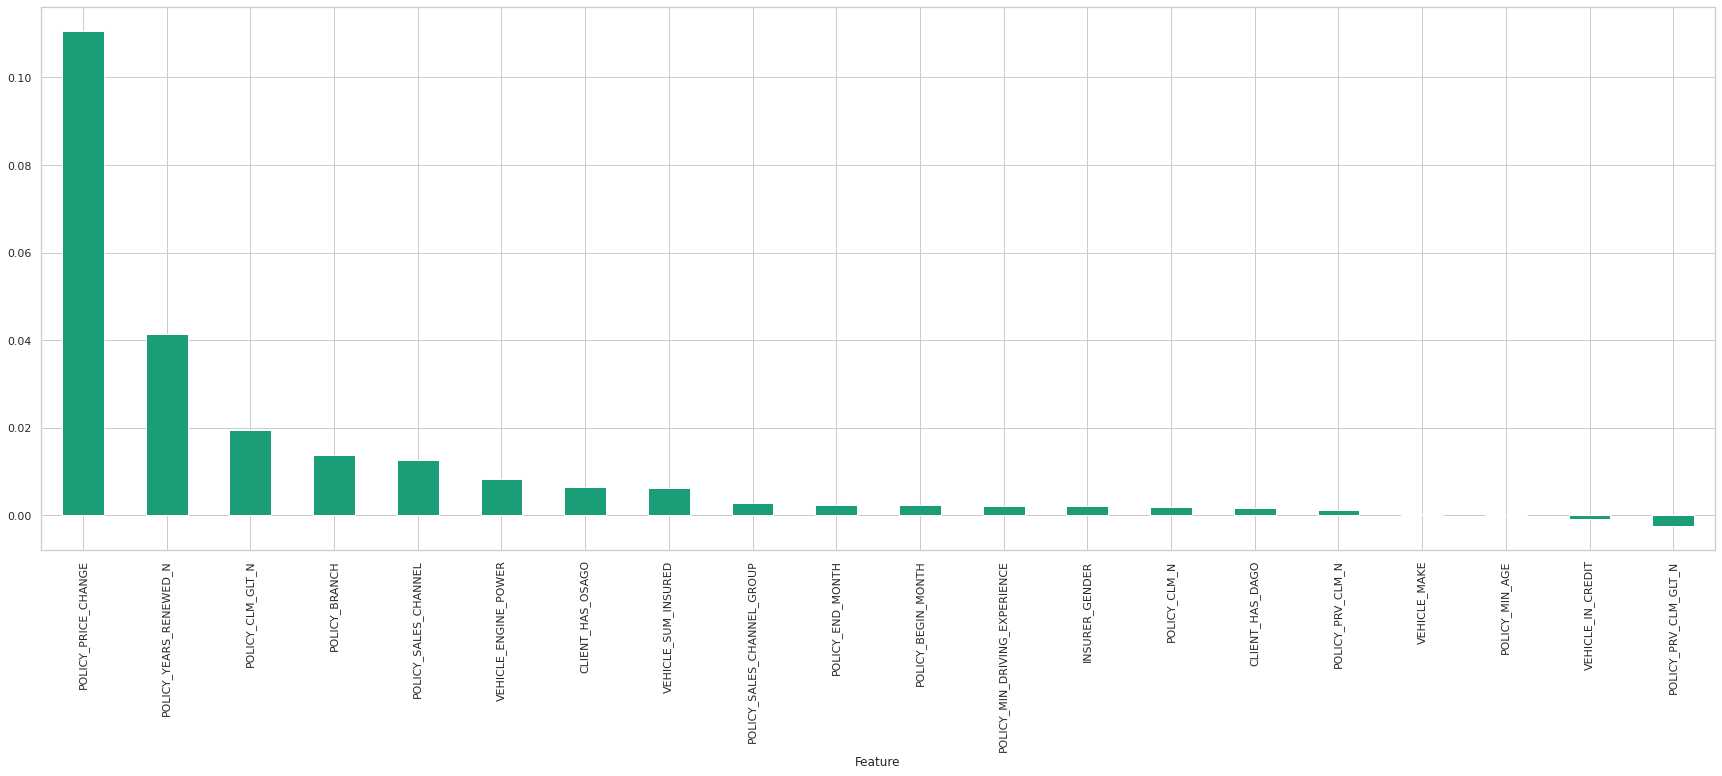

In [ ]:
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [ ]:
best_sc = -1
best_w = None
for w in np.arange(0, 1.01, 0.1):
    sc = f1_score(train_df[TARGET_NAME].values, (oof_pred.data[:, 0] > w).astype(int))
    if sc > best_sc:
        best_sc = sc
        best_w = w
        print(best_sc, round(best_w, 1))

0.6732951113671632 0.0
0.6789123436048095 0.1
0.6911653808225536 0.2
0.7014230534661517 0.3


In [ ]:
test_pred = automl.predict(test_df)

In [ ]:
print('Check scores with optimized threshold...')
print('OOF f1-score: {}'.format(f1_score(train_df[TARGET_NAME].values, (oof_pred.data[:, 0] > best_w).astype(int))))
print('HOLDOUT f1-score: {}'.format(f1_score(test_df[TARGET_NAME].values, (test_pred.data[:, 0] > best_w).astype(int))))

Check scores with optimized threshold...
OOF f1-score: 0.7014230534661517
HOLDOUT f1-score: 0.7034174125305125


In [ ]:
dump(automl, 'predictor_base.joblib')

['predictor_base.joblib']

# Model with Pseudolabelling

In [ ]:
pseudolabels = automl.predict(test_df)

In [ ]:
pseudolabels = (pseudolabels.data[:,0] > best_w).astype(int)

In [ ]:
test_df_pseudo = test_df.copy()
test_df_pseudo[TARGET_NAME] = pseudolabels

In [ ]:
ALL_DF = pd.concat([train_df, test_df_pseudo]).reset_index(drop=True)
print(ALL_DF.shape)

(89236, 21)


In [ ]:
ALL_DF['weight'] = [1.001] * len(train_df) + [0.999] * len(test_df)

### AutoML

In [ ]:
%%time

def f1_metric(y_true, y_pred, sample_weight, **kwargs):
    mask = (sample_weight > 1)
    return f1_score(y_true[mask], (y_pred[mask] > 0.5).astype(int), **kwargs)

task = Task('binary', metric = f1_metric, greater_is_better = True)

CPU times: user 429 µs, sys: 0 ns, total: 429 µs
Wall time: 475 µs


In [ ]:
%%time

roles = {'target': TARGET_NAME,
         'category': cat_cols,
         'numeric': num_cols,
         'weights': 'weight' # for pseudolabelling
         }

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.39 µs


In [ ]:
%%time 

automl_pseudo = TabularAutoML(task = task, 
                               timeout = TIMEOUT,
                               cpu_limit = THREADS,
                               reader_params = {'n_jobs': THREADS, 'cv': FOLDS, 'random_state': RANDOM_STATE},
                               general_params = {'use_algos': [['lgb']]},
                               #tuning_params = {'max_tuning_time': 25 * 60}, # Set 25 minutes for LGBM params tuning
                               lgb_params = {'default_params': {'num_trees': 100000, 'learning_rate': 0.0005, 'early_stopping_rounds': 1000}, # Set smaller LR and more ES rounds
                                             'freeze_defaults': True},
                              )

oof_pred = automl_pseudo.fit_predict(ALL_DF, roles = roles)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

Start automl preset with listed constraints:
- time: 10800 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (89236, 22)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 10788.328351974487 secs
Start fitting Selector_LightGBM ...

===== Start working with fold 0 for Selector_LightGBM =====

Training until validation scores don't improve for 1000 rounds
[100]	valid's binary_logloss: 0.679347	valid's Opt metric: 0.67087
[200]	valid's binary_logloss: 0.673533	valid's Opt metric: 0.67087
[300]	valid's binary_logloss: 0.668234	valid's Opt metric: 0.680213
[400]	valid's binary_logloss: 0.663442	valid's Opt metric: 0.690958
[500]	valid's binary_logloss: 0.659103	valid's Opt metric: 0.696017
[600]	valid's binary_logloss: 0.655112	valid's Opt metric: 0.69702
[700]	valid's binary_logloss: 0.651481	valid's Opt metric: 0.697618
[800]	valid's binary_logloss: 0.648149	valid's Opt metric: 0.697039
[900]	valid's binary_logloss: 0.645086	valid's 

In [ ]:
oof_pred_train = oof_pred.data[:len(train_df), 0]

In [ ]:
print('OOF score: {}'.format(f1_score(train_df[TARGET_NAME].values, (oof_pred_train > 0.5).astype(int))))

OOF score: 0.7002490830171625


In [ ]:
best_sc = -1
best_w = None
for w in np.arange(0, 1.01, 0.01):
    sc = f1_score(train_df[TARGET_NAME].values, (oof_pred_train > w).astype(int))
    if sc > best_sc:
        best_sc = sc
        best_w = w
        print(best_sc, round(best_w, 2))

0.6732951113671632 0.0
0.6733952286688785 0.36
0.6735642441482143 0.37
0.6738412598015049 0.38
0.674590606777577 0.39
0.6756799656399101 0.4
0.6775590551181103 0.41
0.6797646881363602 0.42
0.6826930391783949 0.43
0.6867767720587528 0.44
0.6905047549378202 0.45
0.6935051311739848 0.46
0.6959691510513949 0.47
0.6975336322869954 0.48
0.6993821858409827 0.49
0.7002490830171625 0.5


In [ ]:
best_w

0.5

In [ ]:
print('Check score with optimized threshold...')
print('OOF score: {}'.format(f1_score(train_df[TARGET_NAME].values, (oof_pred_train > best_w).astype(int))))

Check score with optimized threshold...
OOF score: 0.7001532040783982


In [ ]:
%%time

test_pred = automl_pseudo.predict(test_df)
print('Prediction for test data:\n{}\nShape = {}'
              .format(test_pred, test_pred.shape))

Prediction for test data:
array([[0.5727266 ],
       [0.59452987],
       [0.55560356],
       ...,
       [0.60762006],
       [0.5250243 ],
       [0.53459954]], dtype=float32)
Shape = (17848, 1)
CPU times: user 2.35 s, sys: 6.93 ms, total: 2.36 s
Wall time: 1.44 s


In [ ]:
print('HOLDOUT rec-score: {}'.format(recall_score(test_df[TARGET_NAME].values, (test_pred.data[:, 0] > best_w).astype(int))))

print('HOLDOUT prec-score: {}'.format(precision_score(test_df[TARGET_NAME].values, (test_pred.data[:, 0] > best_w).astype(int))))

HOLDOUT rec-score: 0.9101346875689997
HOLDOUT prec-score: 0.5709932123562821


In [ ]:
from sklearn.metrics import precision_recall_curve

test_pred = test_pred.data[:,0]

precision, recall, thresholds = precision_recall_curve(y_true = test_df[TARGET_NAME], probas_pred=test_pred)

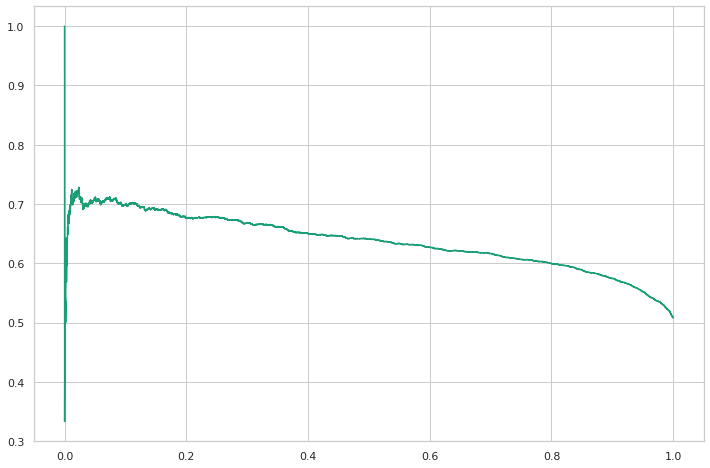

In [ ]:
plt.plot(recall, precision)

# Sklearn

In [62]:
pip install -U scikit-learn

In [162]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score, recall_score, precision_score, plot_precision_recall_curve, precision_recall_curve

In [134]:
class DataPreprocessing():
    def __init__(self, to_numeric=False):
        self.to_numeric = to_numeric
    
    def fit(self, X: pd.DataFrame(), Y = None):
        return self
    
    def transform(self, X: pd.DataFrame(), Y = None) -> pd.DataFrame:
        try:
            to_drop = ['DATA_TYPE', 'VEHICLE_MAKE', 'VEHICLE_MODEL', 'POLICY_INTERMEDIARY',
                        'POLICY_PRV_CLM_GLT_N', 'POLICY_COURT_SIGN', 'CLAIM_AVG_ACC_ST_PRD',
                        'CLIENT_REGISTRATION_REGION']

            new_data = X.copy()
            new_data.drop(labels=to_drop, inplace=True, axis=1, errors='ignore')

            if self.to_numeric:
                # POLICY_BRANCH
                new_data['POLICY_BRANCH'] = new_data['POLICY_BRANCH'].replace({'Москва':1, 'Санкт-Петербург':0})
                # INSURER_GENDER
                new_data['INSURER_GENDER'] = new_data['INSURER_GENDER'].replace({'F':0, 'M':1})
                # POLICY_CLM_N
                new_data['POLICY_CLM_N'] = new_data['POLICY_CLM_N'].replace({'0':0, '1L':1, '1S':2, 
                                                                             '2':3, '3':4, '4+':5, 'n/d':6})
                # POLICY_CLM_GLT_N
                new_data['POLICY_CLM_GLT_N'] = new_data['POLICY_CLM_GLT_N'].replace({'0':0, '1L':1, '1S':2, '2':3, 
                                                                                     '3':4, '4+':5, 'n/d':6})
                # POLICY_PRV_CLM_N
                new_data['POLICY_PRV_CLM_N'] = new_data['POLICY_PRV_CLM_N'].replace({'0':0, '1L':1, '1S':2, '2':3, 
                                                                                     '3':4, '4+':5, 'N':6})
                # POLICY_YEARS_RENEWED_N
                new_data['POLICY_YEARS_RENEWED_N'] = new_data['POLICY_YEARS_RENEWED_N']. \
                                                    replace({'0':0, '1':1, '2':2, '3':3, '4':4, '5':5, '6':6,
                                                            '7':7, '8':8, '9':9, '10':10, 'N':11})
        
            return new_data
        except Exception as err:
            print('DataPreprocessing.transform(): {}'.format(err))
        return X

    def fit_transform(self, X: pd.DataFrame, Y = None):
        self.fit(X)
        return self.transform(X)
                    

### Pipeline, fitting

In [135]:
train_df = pd.read_csv('data/train.csv', index_col='POLICY_ID')
test_df = pd.read_csv('data/test.csv', index_col='POLICY_ID')

X_train = train_df.drop(TARGET_NAME, axis=1)
y_train = train_df[TARGET_NAME]

X_test = test_df.drop(TARGET_NAME, axis=1)
y_test = test_df[TARGET_NAME]

In [136]:
from sklearn.pipeline import Pipeline

In [141]:
model_pipeline = Pipeline([
                           ('preparing', DataPreprocessing(to_numeric=True)),
                           ('model', RandomForestClassifier(random_state=RANDOM_STATE))
])

In [142]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preparing',
                 <__main__.DataPreprocessing object at 0x7faeb9e80a50>),
                ('model', RandomForestClassifier(random_state=73))])

In [150]:
pred = (model_pipeline.predict_proba(X_test)[:,1] > 0.28).astype(int)
f1_score(y_true=y_test, y_pred=pred)

0.6931979392219817

In [173]:
def score(model, X, y):
    pred = model.predict(X)
    proba = model.predict_proba(X)[:,1]

    best_sc = -1
    best_w = None
    for w in np.arange(0, 1.01, 0.01):
        sc = f1_score(y, (proba > w).astype(int))
        if sc > best_sc:
            best_sc = sc
            best_w = w

    r = recall_score(y, pred)
    p = precision_score(y, pred)

    precision, recall, threshold = precision_recall_curve(y, proba)
    print(f'Prec: {p}\nRecall: {r}\nf1: {best_sc}\nthreshold: {best_w}')
    plot_precision_recall_curve(model, X, y)
    plt.show()
    return precision, recall, best_w

Prec: 0.6051414832624376
Recall: 0.6763824289405684
f1: 0.6959339557132938
threshold: 0.33


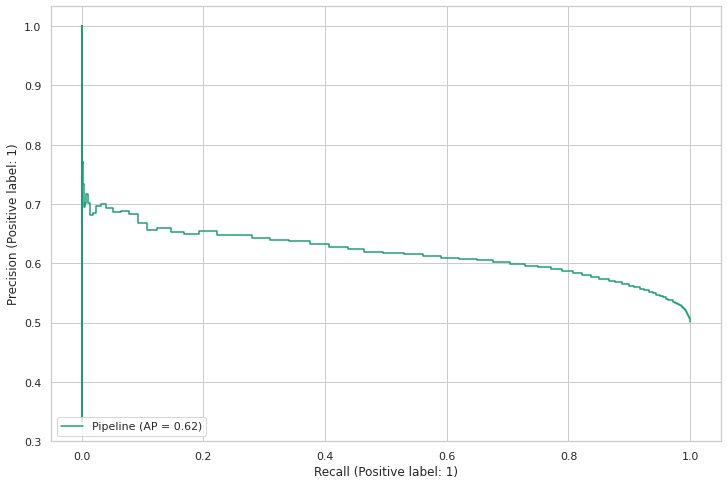

In [174]:
prec, rec, threshold = score(model_pipeline, X_test, y_test)

### GridSearch

In [177]:
from sklearn.model_selection import GridSearchCV

In [192]:
grid_pipeline = Pipeline([
                          ('preparing', DataPreprocessing(to_numeric=True)),
                          ('model', GridSearchCV(
                              RandomForestClassifier(random_state=RANDOM_STATE),
                              param_grid={'n_estimators':[200,400],
                                          'max_depth':[10,20,40,70],
                                          'min_samples_split': [5, 10],
                                          'min_samples_leaf': [2, 4],

                                          },
                                          cv=3,
                                          verbose=4,
                                          n_jobs=-1
                          ))
])

In [193]:
grid_pipeline.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


Pipeline(steps=[('preparing',
                 <__main__.DataPreprocessing object at 0x7faeb782d5d0>),
                ('model',
                 GridSearchCV(cv=3,
                              estimator=RandomForestClassifier(random_state=73),
                              n_jobs=-1,
                              param_grid={'max_depth': [10, 20, 40, 70],
                                          'min_samples_leaf': [2, 4],
                                          'min_samples_split': [5, 10],
                                          'n_estimators': [200, 400]},
                              verbose=4))])

In [196]:
grid_pipeline['model'].best_params_

{'max_depth': 20,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 400}

### GS Model

In [198]:
model_pipeline = Pipeline([
                           ('preparing', DataPreprocessing(to_numeric=True)),
                           ('model', RandomForestClassifier(random_state=RANDOM_STATE,
                                                            max_depth=20,
                                                            min_samples_leaf=4,
                                                            min_samples_split=10,
                                                            n_estimators=400))
])

In [199]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preparing',
                 <__main__.DataPreprocessing object at 0x7faeb77ff290>),
                ('model',
                 RandomForestClassifier(max_depth=20, min_samples_leaf=4,
                                        min_samples_split=10, n_estimators=400,
                                        random_state=73))])

Prec: 0.6073125212080082
Recall: 0.7399483204134367
f1: 0.7019836456825386
threshold: 0.37


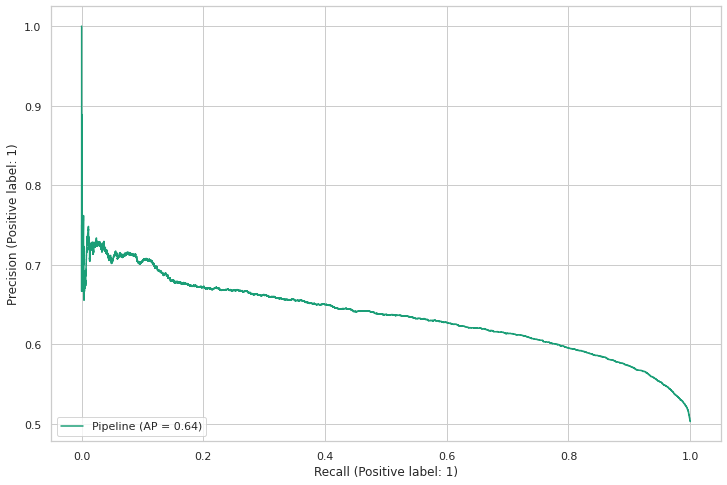

In [200]:
prec, rec, threshold = score(model_pipeline, X_test, y_test)

threshold: 0.37

In [218]:
from sklearn.metrics import confusion_matrix

pred = (model_pipeline.predict(X_test) > 0.37).astype(int)

cm = confusion_matrix(y_test, pred)/len(X_test)
cm

array([[0.25966565, 0.23958387],
       [0.130221  , 0.37052948]])

In [219]:
cm[0,0] + cm[1,1]

0.6301951244759588

# Saving model 

In [204]:
from joblib import dump, load

dump(model_pipeline, 'model_pipeline.joblib')

['model_pipeline.joblib']

# Conclusion

Oddly enough, the RandomForestClassification with GridSearch got the best score! 

I saved this model and will use it for my app.